# Advanced Regression techniques

#DataAugmentation#nolinearmodeling#interactionModel

Hello Everyone! 
<br>
The link for this challenge is the following: https://www.kaggle.com/c/house-prices-advanced-regression-techniques


<b> Context

Use ML techniques to predict the price house
<br>
The challenge is to deal with a high number of categorical features

<b> Methodology

* Creation of interaction terms
* creation of non linear features
* Selecting relevant features
* Modeling using a linear regression methods
* usin hold out cross validation for assessment

<b> Result

Final test using Mean Logaritmic Square Error and some remarks

### General Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  

import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso , LinearRegression, RANSACRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error

In [4]:
import math

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from ARTfuncs import dict_to_replace,dict_to_replace_2, additional_numerical, additional_categorical, replacer_categorical, replacer_categorical_2 
from ARTfuncs import convert_categoricals, control_outlier_numerical, convert_TotalBsmtSF, split_category_in_categorical, years_vars_and_extra_numericasl, mask_feature,feature_transformation_1

## Processing

the submission contains the forecasted prices, then I merge the submission and the Test set

In [25]:
train = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\train.csv')
ss = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\sample_submission.csv')
test = pd.read_csv(r'C:\Users\Miguel\kaggle\ART\test.csv')
test = test.merge(ss, left_on = 'Id', right_on = 'Id', how = 'inner')

In [26]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Splitting train data

no time split

In [27]:
test.YrSold.unique(), train.YrSold.unique()

(array([2010, 2009, 2008, 2007, 2006], dtype=int64),
 array([2008, 2007, 2006, 2009, 2010], dtype=int64))

Try random split

In [28]:
def columniser(data,target,numericals, categoricals):
    data = data[categoricals + numericals + [target]]
    return data

In [29]:
numericals_to_use = ['GrLivArea','OverallQual','TotRmsAbvGrd','GarageCars','FullBath','Neighborhood','year_age','year_remod']
categoricals_to_use = ['MasVnrType','Fireplaces','SaleCondition','BsmtExposure','BsmtFinType1','GenQual']

In [30]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed)
validation_dataset = validation_dataset.copy()
train_dataset = train[~train.index.isin(validation_dataset.index)]

train_dataset = feature_transformation_1(train_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
train_dataset = columniser(train_dataset,'SalePrice',numericals_to_use, categoricals_to_use)

#### Feature Modeling

In [31]:
def scaler(dataset):
    scaler = StandardScaler()
    scaler.fit(dataset)

    dataset_scaled = scaler.transform(dataset)

    return dataset_scaled, scaler

In [32]:
def testing_regression(y,x1,x2,category,order = 1,plot = False, printer = True):
    category_list = train_dataset[x2].unique()

    dataset = train_dataset[(train_dataset[x2] == category) & (train_dataset[x1] != 0)]
    if order >1:
        order_columns = list()
        for orderx in range(2,order+1):
            new_column = f'{x1}_order_{orderx}'
            dataset[new_column] = dataset[x1]**orderx
            order_columns.append(new_column)
        dataset = dataset[[x1] + order_columns + [y]]
    else:
        dataset = dataset[[x1] + [y]]
    header = dataset.columns

    dataset_scaled, _ = scaler(dataset = dataset)
    dataset_scaled = pd.DataFrame(data = dataset_scaled, columns = header)

    ## Testing RanSag Regression using the normalized and scaled data
    X = dataset_scaled.loc[:,dataset_scaled.columns != y].values
    Y = dataset_scaled.loc[:,y].values
    #X = X.reshape((X.shape[0],1))
    #Y = Y.reshape((Y.shape[0],1))
    
    linearModel = LinearRegression()
    linearModel.fit(X, Y)
    Y_pred = linearModel.predict(X)
    
    dataset_scaled['Y_pred'] = Y_pred
    
    if plot:
        
        fig, ax = plt.subplots(1,2 ,figsize=(18.0, 8.0))
        sns.regplot( data = dataset, x = x1 , y = y , ax = ax[0])
        ax[0].set_title(x1, fontsize=12)

        ax[1].scatter(dataset_scaled[x1], dataset_scaled[y])
        ax[1].plot(dataset_scaled.sort_values(x1)[x1], dataset_scaled.sort_values(x1)['Y_pred'])
        ax[1].set_title('RansacReg', fontsize=12)
    MAE = mean_absolute_error(Y,Y_pred)
    R_square = r2_score(Y,Y_pred)
    if printer:
        print(f'numerical: {x1} catategorical: {x2} category: {category}  MAE:{MAE} R":{R_square}')
    return MAE, R_square, len(dataset_scaled)

numerical: year_age catategorical: Fireplaces category: 0  MAE:0.5379203355240291 R":0.5062885739674452


(0.5379203355240291, 0.5062885739674452, 491)

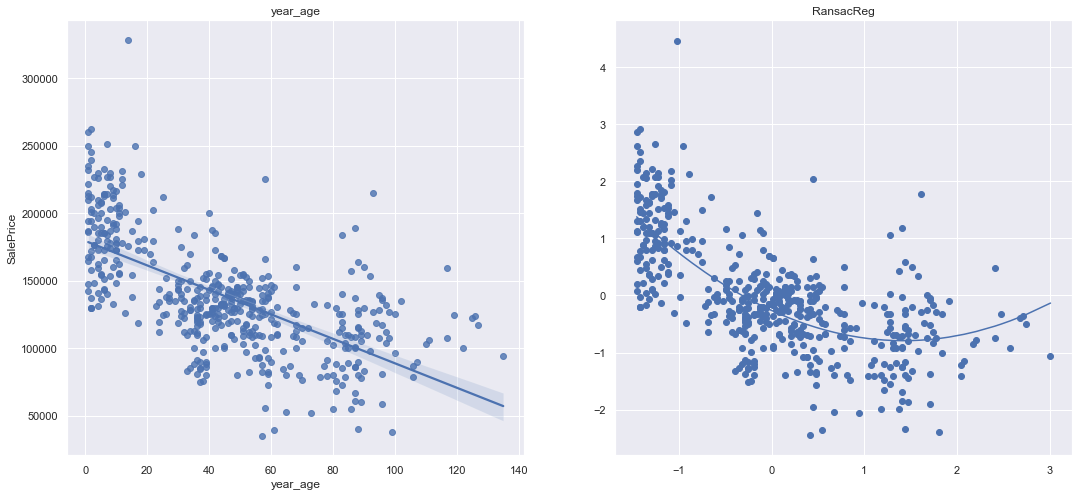

In [33]:
x1 = 'year_age' ## numerical
x2 = 'Fireplaces' ## Categorical
category = 0 ## category
y = "SalePrice"
testing_regression(y,x1,x2,category, 2 , True, True)

goal: detech low absolute error categories with multiple regresion technique

In [34]:
Numerical_list_to_test = ['GrLivArea']
target = "SalePrice"
categoricals_list_to_test = ['GenQual']
Order = [1,2,3]

reg_numerical_list = list()
reg_categorical_list = list()
reg_category_list = list()
MAE_list = list()
Rsquare_list = list()
size_list = list()
order_list = list()

for num_variable in Numerical_list_to_test:
    for cat_variable in categoricals_list_to_test:
        for category in train_dataset[cat_variable].unique():
            for orderx in Order:
                MAE, R_square, lendf= testing_regression(target,num_variable,cat_variable,category, orderx , False,False)

                reg_numerical_list.append(num_variable)
                reg_categorical_list.append(cat_variable)
                reg_category_list.append(category)
                MAE_list.append(MAE)
                Rsquare_list.append(R_square)
                size_list.append(lendf)
                order_list.append(orderx)

dict_data = {'NumercialVar': reg_numerical_list, 'CategoricalVar': reg_categorical_list, 'Category': reg_category_list, 'MAE': MAE_list, 'R2': Rsquare_list, 'size': size_list, 'Order' : order_list}
summaryDF = pd.DataFrame(dict_data).sort_values(['Category','MAE'])

In [35]:
summaryDF.head()

,NumercialVar,CategoricalVar,Category,MAE,R2,size,Order
11,GrLivArea,GenQual,Fa,0.519678,0.514639,83,3
10,GrLivArea,GenQual,Fa,0.519792,0.512746,83,2
9,GrLivArea,GenQual,Fa,0.522374,0.509938,83,1
2,GrLivArea,GenQual,Gd,0.463753,0.552626,638,3
1,GrLivArea,GenQual,Gd,0.471950,0.540045,638,2


numerical: GrLivArea catategorical: GenQual category: TA  MAE:0.6383128338646453 R":0.3055664124041545


(0.6383128338646453, 0.3055664124041545, 345)

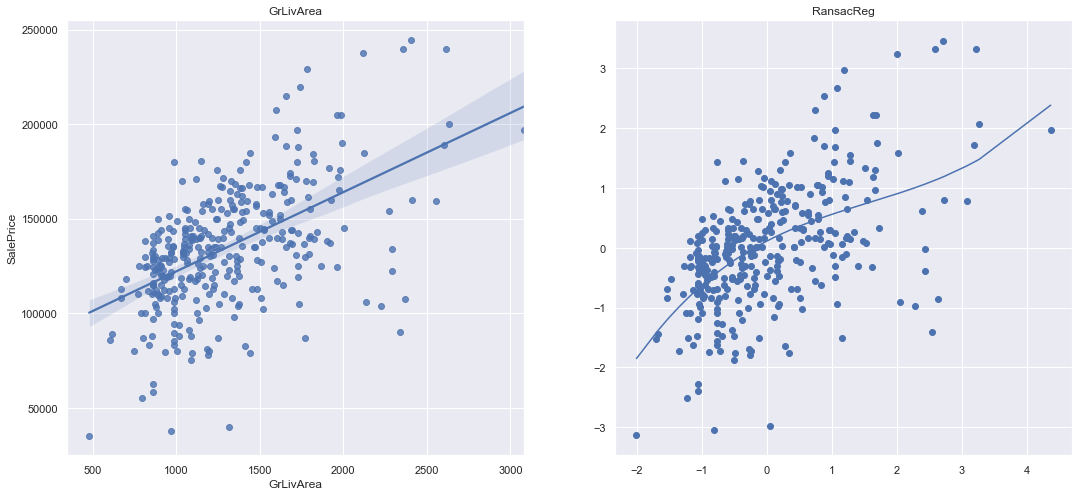

In [36]:
x1 = 'GrLivArea' ## numerical
x2 = 'GenQual' ## Categorical
category = 'TA' ## category
Order = 3
y = "SalePrice"
testing_regression(y,x1,x2,category, Order , True)

Key issues until here:
* combination of variables were taken using the low standarized and normalized errors using robust linear regression
* variables are separate in a different excel file
* one for the data that forms clouds and another for data that have empties regression models

#### Additive modeling 

In [37]:
path_x = r'C:\Users\Miguel\Dropbox\kaggle datasets\advanced regressions\summary variables robust regression.xlsx'
excel_file = pd.ExcelFile(path_x) 
regs = excel_file.parse("Hoja1")

In [38]:
regs.head()

,Unnamed: 0,NumercialVar,CategoricalVar,Category,MAE,R2,size,Order
0,2,GrLivArea,MasVnrType,BrkFaceN0,0.434090,0.614356,209,3
1,9,GrLivArea,MasVnrType,Stone0,0.458577,0.596009,94,1
2,7,GrLivArea,MasVnrType,Stone1,0.496538,0.531873,16,2
3,5,GrLivArea,MasVnrType,None,0.497243,0.499491,659,3
4,14,GrLivArea,MasVnrType,BrkFaceN1,0.583961,0.463368,117,3


In [39]:
len(regs)

40

In [40]:
empties_columns = list()
for categorical in categoricals_to_use:
    for category in train_dataset[categorical].unique():
        dummy = categorical + '_' +str(category)
        empties_columns.append(dummy)

In [41]:
selected_dummies = empties_columns

In [42]:
def prep_interactin_terms(dataset, WholeCategoricals, WholeNumericals, SelectedDummies, dataReferencial, scale = False,
                          scalers_exist = None,lambdas_exist = None, base_columns = None ):
    ## getting the dummies
    dataset = dataset.copy()
    dummies = pd.get_dummies(dataset[WholeCategoricals])
    new_dataset = pd.concat([dummies,dataset[WholeNumericals + ['SalePrice']]],axis = 1)

    missingcolumns = [x for x in SelectedDummies if x not in new_dataset.columns]
    for col in missingcolumns:
        new_dataset[col] = 0
        
    ## getting the interaction terms
    interaction_terms_list = list()
    for i in range(len(dataReferencial)):
        rows_var = dataReferencial.iloc[i,::]
        numerical_var,categorical_var, category_x, order_x = rows_var.NumercialVar,rows_var.CategoricalVar,rows_var.Category,rows_var.Order

        for ords in range(1,order_x+1):
            interaction_term = f'{categorical_var}_{category_x}_{numerical_var}_ord{ords}'
            categorical = f'{categorical_var}_{category_x}'
            new_dataset[interaction_term] = new_dataset[categorical] * new_dataset[numerical_var] ** ords
            interaction_terms_list.append(interaction_term)
    
    
    ## getting the numericals and categoricals

    cat_columns_computed = SelectedDummies
    cat_columns_computed = list(set(cat_columns_computed))
    num_columns_computed = WholeNumericals + interaction_terms_list
    num_columns_computed = list(set(num_columns_computed))
    
    ###Result dataset with no scaling:
    dataset_treated = new_dataset[num_columns_computed + cat_columns_computed + ['SalePrice']].reset_index(drop = True)
    
    ### scaling
    if scale == True:
        
        data_toscale = dataset_treated.copy()
        dataset = data_toscale[num_columns_computed + ['SalePrice']]
        
        ## Scaling from 0 to 1
        data_scaled, scalerx = scaler(dataset = dataset)
        data_scaled = pd.DataFrame(data = data_scaled, columns = num_columns_computed + ['SalePrice']).reset_index(drop = True)

        dataset_treated = pd.concat([data_scaled[num_columns_computed], dataset_treated[cat_columns_computed ] , data_scaled['SalePrice'] ], axis = 1)
            
        return dataset_treated, scalerx, num_columns_computed, cat_columns_computed, interaction_terms_list
    
    if scale == False:
        ## creqting not existing feqtures 
        whole_base_columns = base_columns[0] + base_columns[1]
        missingcolumns = [x for x in whole_base_columns if x not in dataset_treated.columns ]
        for col in missingcolumns:
            dataset_treated[col] = 0
            
        numericals_list = base_columns[0]
        categoricals_list = base_columns[1]
        data_numericals = dataset_treated[numericals_list + ['SalePrice']]
        data_categoricals = dataset_treated[categoricals_list]
        
        data_numericals = scalers_exist.transform(data_numericals)
        data_numericals = pd.DataFrame(data_numericals, columns = numericals_list + ['SalePrice'])
       
        dataset_reconverted = pd.concat([data_numericals,data_categoricals ], axis = 1)
        dataset_reconverted = dataset_reconverted[numericals_list + list(categoricals_list) + ['SalePrice'] ]
        
        if missingcolumns:
            for col in missingcolumns:
                dataset_reconverted[col] = 0
                
        return dataset_reconverted

In [43]:
scaled_train_dataset, scalerx, num_columns_head, cat_columns_head, interaction_terms_list = prep_interactin_terms(dataset = train_dataset,
                                                    WholeCategoricals = categoricals_to_use,
                                                    WholeNumericals = numericals_to_use, SelectedDummies = selected_dummies,
                                                    dataReferencial = regs, scale =  True)

In [44]:
scaled_train_dataset.head()

,FullBath,MasVnrType_Stone1_year_age_ord3,Neighborhood,MasVnrType_BrkFaceN1_year_age_ord1,GrLivArea,Fireplaces_1_year_age_ord1,MasVnrType_BrkFaceN0_GrLivArea_ord1,SaleCondition_Partial_OverallQual_ord1,year_remod,MasVnrType_Stone1_GrLivArea_ord1,...,BsmtFinType1_GLQ0,Fireplaces_1,GenQual_Sup,MasVnrType_BrkFaceN0,MasVnrType_Stone0,SaleCondition_Abnorml,MasVnrType_Stone1,MasVnrType_None,Fireplaces_0,SalePrice
0,0.750892,-0.097493,0.643667,-0.334763,0.393411,0.0,1.873592,-0.309876,-0.870835,-0.117637,...,1,0,0,1,0,0,0,0,0,0.330451
1,0.750892,-0.097493,0.643667,-0.334763,-0.496743,0.0,-0.461317,-0.309876,0.383855,-0.117637,...,0,0,0,0,0,0,0,1,0,-0.001078
2,0.750892,-0.097493,0.643667,-0.334763,0.544419,0.0,1.977366,-0.309876,-0.822578,-0.117637,...,1,0,0,1,0,0,0,0,0,0.514633
3,-1.048291,-0.097493,0.643667,-0.334763,0.407319,0.0,-0.461317,-0.309876,0.625141,-0.117637,...,0,0,0,0,0,1,0,1,0,-0.510649
4,0.750892,2.451842,0.643667,-0.334763,1.148451,0.0,-0.461317,-0.309876,0.625141,10.369179,...,0,0,0,0,0,0,1,0,0,0.226080


In [45]:
def prob(x,mean , sd):
    s = sp.stats.norm(mean, sd).pdf(x)
    return round(s,4)

In [46]:
def try_augmentation(data, target, numericals, categoricals, seed, n ):
    data = data.copy()
    meany, stdy = np.mean(data[target]),np.std(data[target])
    data['vector'] = data.apply(lambda x: prob(x[target], meany, stdy), axis=1)
    data_sample = data.sample(n = n, weights = 'vector', random_state = seed)
    data_sample = data_sample.reset_index(drop= True)
    
    ## adding noise to numericals
    for i in data_sample.index:
        q75, q25 = np.percentile(data_sample[target], [75 ,25])
        iqr = q75 - q25
        rangex = iqr * 0.1
        noise = np.random.uniform(0,rangex,1)[0]
        data_sample.loc[i,target] = data_sample.loc[i,target] + noise
    data_sample = data_sample.drop(columns = 'vector')
    return data_sample

In [47]:
augmented_data_train = try_augmentation(scaled_train_dataset, 'SalePrice', num_columns_head, cat_columns_head, 152, 500)

(<matplotlib.axes._subplots.AxesSubplot at 0x18b0ea37588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18b0ea37588>)

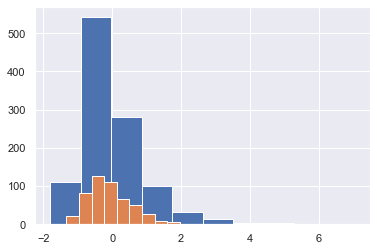

In [48]:
scaled_train_dataset.SalePrice.hist(), augmented_data_train.SalePrice.hist()

## Feature Selection

In [49]:
len(scaled_train_dataset.columns) -1

126

In [50]:
numericals_no_interaction = [x for x in num_columns_head if x not in interaction_terms_list] 
features_no_interaction = cat_columns_head + numericals_no_interaction
len(features_no_interaction)

32

In [51]:
X = scaled_train_dataset[features_no_interaction].iloc[:,0:-1]
Y = scaled_train_dataset[['SalePrice']].iloc[:,-1]

In [52]:
lr = LinearRegression(fit_intercept=True)
rfe = RFE(estimator = lr, n_features_to_select=10, step=1)
rfe.fit(X, Y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=10, step=1, verbose=0)

In [53]:
[(x,y) for x,y in zip(list(rfe.ranking_), features_no_interaction)]

[(1, 'GenQual_Fa'),
 (1, 'BsmtExposure_Null'),
 (10, 'BsmtExposure_Gd'),
 (1, 'GenQual_Gd'),
 (7, 'BsmtFinType1_LwQ'),
 (12, 'BsmtExposure_No'),
 (11, 'BsmtExposure_Av'),
 (1, 'GenQual_TA'),
 (3, 'MasVnrType_BrkFaceN1'),
 (6, 'BsmtFinType1_GLQ1'),
 (5, 'BsmtFinType1_Unf'),
 (21, 'Fireplaces_2'),
 (1, 'SaleCondition_Partial'),
 (8, 'SaleCondition_Normal'),
 (1, 'BsmtFinType1_Null'),
 (1, 'BsmtFinType1_GLQ0'),
 (20, 'Fireplaces_1'),
 (1, 'GenQual_Sup'),
 (1, 'MasVnrType_BrkFaceN0'),
 (1, 'MasVnrType_Stone0'),
 (9, 'SaleCondition_Abnorml'),
 (4, 'MasVnrType_Stone1'),
 (2, 'MasVnrType_None'),
 (22, 'Fireplaces_0'),
 (18, 'FullBath'),
 (15, 'Neighborhood'),
 (13, 'GrLivArea'),
 (19, 'year_remod'),
 (14, 'OverallQual'),
 (16, 'TotRmsAbvGrd'),
 (17, 'year_age')]

In [36]:
numericals = ['GrLivArea', 'Neighborhood', 'OverallQual']
categoricals = ['GenQual', 'BsmtExposure', 'SaleCondition', 'BsmtFinType1']

selected_interaction_terms = list()
for int_term in interaction_terms_list:
    int_term_tokens = int_term.split('_')
    if int_term_tokens[0] in categoricals and int_term_tokens[2] in numericals:
        selected_interaction_terms.append(int_term)
        
dummies_from_int_terms = list()
for int_term in selected_interaction_terms:
    int_term_tokens = int_term.split('_')
    if int_term_tokens[0] in categoricals:
        dummi_label = int_term_tokens[0] + '_' + int_term_tokens[1]
        dummies_from_int_terms.append(dummi_label)
dummies_from_int_terms = list(set(dummies_from_int_terms))

In [37]:
selected_interaction_terms
selected_categorical_features = categoricals
selected_categorical_dummies_features = dummies_from_int_terms
selected_numerical_features = numericals
len(selected_categorical_features + selected_interaction_terms + selected_numerical_features)

63

<b> the features are save in ARTfuncs

## Modeling Machines

### Robust linear Regresion

In [38]:
int_terms_df = regs.copy()
int_terms_df['var_name'] =  int_terms_df.CategoricalVar.astype(str) + '_' + int_terms_df.Category.astype(str)  + '_' + int_terms_df.NumercialVar.astype(str)  + '_ord' + int_terms_df.Order.astype(str)
int_terms_df = int_terms_df[int_terms_df.var_name.isin(selected_interaction_terms)].drop(columns = 'var_name')

the matrix is saved

In [39]:
int_terms_df.to_csv('Interaction Terms.csv')

In [40]:
scaled_train_dataset, scalerx, num_columns_head, cat_columns_head, interaction_terms_list = prep_interactin_terms(dataset = train_dataset,
                                                    WholeCategoricals = selected_categorical_features,
                                                    WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                                                    dataReferencial = int_terms_df, scale =  True)

In [41]:
augmented_data_train = try_augmentation(scaled_train_dataset, 'SalePrice', num_columns_head, cat_columns_head, 152, 500)

In [42]:
## If augmented data
def traindata_totrain(data, augmentation, augment = False):
    if augment:
        data_result = pd.concat([scaled_train_dataset,augmented_data_train],axis = 0, ignore_index = True)
        #data_result = [selected_features + ['SalePrice']]
    else:
        data_result = data
    return data_result

In [43]:
train_dataset_touse = traindata_totrain(scaled_train_dataset, augmented_data_train, augment = True)
train_dataset_touse = train_dataset_touse.copy()

In [44]:
X__train = train_dataset_touse.iloc[:,0:-1]
Y_train = train_dataset_touse.iloc[:,-1]

In [45]:
X__train_reten = X__train.assign(intercept = 1) ### artificial intercept

In [46]:
X__train_reten.head(5)

,SaleCondition_Normal_OverallQual_ord2,BsmtExposure_Av_Neighborhood_ord1,BsmtFinType1_LwQ_GrLivArea_ord3,BsmtExposure_No_Neighborhood_ord1,BsmtFinType1_LwQ_GrLivArea_ord2,BsmtFinType1_Null_GrLivArea_ord1,BsmtFinType1_Unf_GrLivArea_ord2,BsmtExposure_Av_GrLivArea_ord2,BsmtExposure_Av_GrLivArea_ord3,SaleCondition_Normal_OverallQual_ord3,...,GenQual_TA,BsmtExposure_Av,BsmtExposure_No,BsmtFinType1_Null,BsmtExposure_Gd,GenQual_Gd,BsmtFinType1_GLQ0,GenQual_Fa,BsmtFinType1_Unf,intercept
0,0.856695,-0.479860,-0.335129,1.222515,-0.425226,-0.16325,-0.656542,-0.418798,-0.324241,0.784339,...,0,0,1,0,0,1,1,0,0,1
1,0.212715,-0.479860,-0.335129,-0.976325,-0.425226,-0.16325,0.295761,-0.418798,-0.324241,0.049066,...,0,0,0,0,1,1,0,0,1,1
2,0.856695,1.982403,-0.335129,-0.976325,-0.425226,-0.16325,-0.656542,1.860718,1.346153,0.784339,...,0,1,0,0,0,1,1,0,0,1
3,-1.570614,-0.479860,-0.335129,1.222515,-0.425226,-0.16325,1.106233,-0.418798,-0.324241,-1.201477,...,0,0,1,0,0,1,0,0,1,1
4,0.856695,1.982403,-0.335129,-0.976325,-0.425226,-0.16325,1.955312,2.702767,2.352544,0.784339,...,0,1,0,0,0,1,0,0,1,1


In [47]:
linearModelRanSac = RANSACRegressor(max_trials = 240, random_state = 95, loss = 'squared_loss',max_skips = 85)
linearModelRanSac.fit(X__train_reten, Y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='squared_loss', max_skips=85, max_trials=240,
                min_samples=None, random_state=95, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [48]:
Y_pred = linearModelRanSac.predict(X__train_reten)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.DataFrame({'y_train': Y_train, 'y_pred':Y_pred.reshape((Y_pred.shape[0],))})
df = df.assign(error = df.y_pred - df.y_train)

In [49]:
#df.sort_values('error')

In [50]:
def inverse_scaling(X,Y,scalers, numericals_list, categoricals_list):
    data_numericals = X[numericals_list]
    data_numericals['SalePrice'] = Y
    data_categoricals = X[categoricals_list]
    
    data_numericals = scalers.inverse_transform(data_numericals)
    data_numericals = pd.DataFrame(data_numericals, columns = numericals_list + ['SalePrice'])

    dataset_reconverted = pd.concat([data_numericals,data_categoricals ], axis = 1, ignore_index = False)
    dataset_reconverted = dataset_reconverted[numericals_list + list(categoricals_list) + ['SalePrice'] ].reset_index(drop = True)
    return dataset_reconverted

In [51]:
def dataframe_to_plot(data1,data2):
    df_plot = data1[['SalePrice']]
    df_plot['y_pred'] = data2[['SalePrice']]
    df_plot['y_pred'] = abs(df_plot['y_pred'])
    df_plot['error'] = df_plot['y_pred'] - df_plot['SalePrice']
    return df_plot

In [52]:
def plot_error_distrib(data):
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(23,6))

    sns.scatterplot(ax = axs[0] ,data = df_plot, x = df_plot.index, y = 'error')
    sns.scatterplot(ax = axs[1] ,data = df_plot, y = df_plot.SalePrice, x = 'error')
    sns.histplot(ax = axs[2] , data=df_plot, x="y_pred")
    fig.show()

In [53]:
def correct_extreme_values(array):
    med = np.median(array)
    array_result = np.where(array > 845000, med, array)
    return array_result

In [54]:
train_inversed_scaled_data = inverse_scaling(X__train, Y_train, scalerx, num_columns_head, cat_columns_head)
trainpred_inversed_scaled_data = inverse_scaling(X__train, Y_pred, scalerx, num_columns_head, cat_columns_head)

In [55]:
df_plot = dataframe_to_plot(train_inversed_scaled_data, trainpred_inversed_scaled_data)
df_plot['y_pred'] = correct_extreme_values(df_plot['y_pred'])
df_plot['error'] = df_plot['SalePrice'] - df_plot['y_pred']

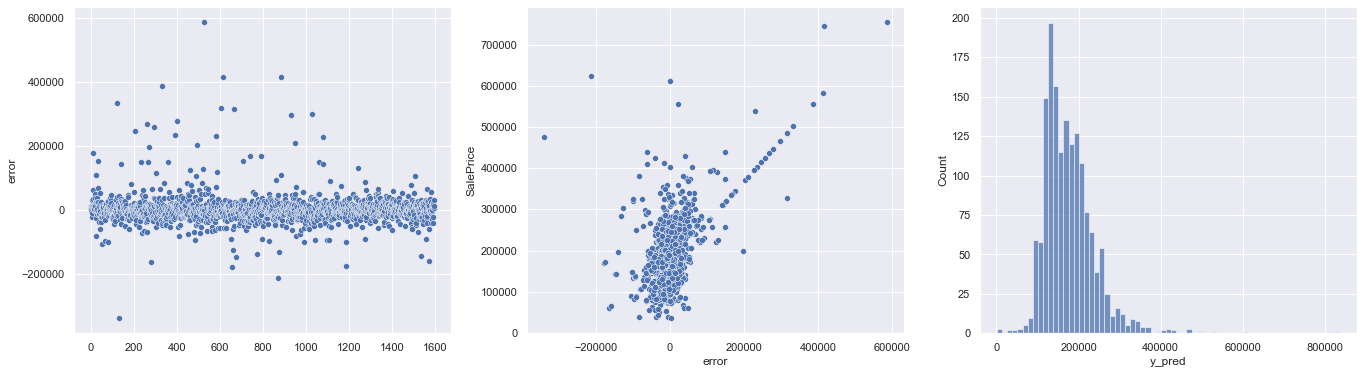

In [56]:
plot_error_distrib(df_plot)

In [57]:
def gets_metrics(dataplot,typex):
    train_msle = mean_squared_log_error(dataplot.SalePrice,dataplot.y_pred)
    train_mae = mean_absolute_error(dataplot.SalePrice,dataplot.y_pred)
    train_mets = {typex: {'MSLE':train_msle,'MAE':train_mae}}
    return train_mets

In [58]:
ransag_train_metrcs = gets_metrics(df_plot,'Train')
ransag_train_metrcs

{'Train': {'MSLE': 0.0717440822463639, 'MAE': 25237.592780232088}}

<b> Validation Data

In [59]:
validation_dataset_prep = feature_transformation_1(validation_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
validation_dataset_prep = columniser(validation_dataset_prep,'SalePrice',numericals_to_use, categoricals_to_use)

In [60]:
scaled_validation_dataset = prep_interactin_terms(dataset = validation_dataset_prep,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [61]:
X__validation = scaled_validation_dataset.iloc[:,0:-1]
Y_validation = scaled_validation_dataset.iloc[:,-1]
X__validation_reten = X__validation.assign(intercept = 1) ### artificial intercept
Y_validation_pred = linearModelRanSac.predict(X__validation_reten)

In [62]:
validation_inversed_scaled_data = inverse_scaling(X__validation, Y_validation, scalerx, num_columns_head, cat_columns_head)
validationpred_inversed_scaled_data = inverse_scaling(X__validation, Y_validation_pred, scalerx, num_columns_head, cat_columns_head)

In [63]:
df_plot = dataframe_to_plot(validation_inversed_scaled_data, validationpred_inversed_scaled_data)
df_plot['y_pred'] = correct_extreme_values(df_plot['y_pred'])
df_plot['error'] = df_plot['SalePrice'] - df_plot['y_pred']

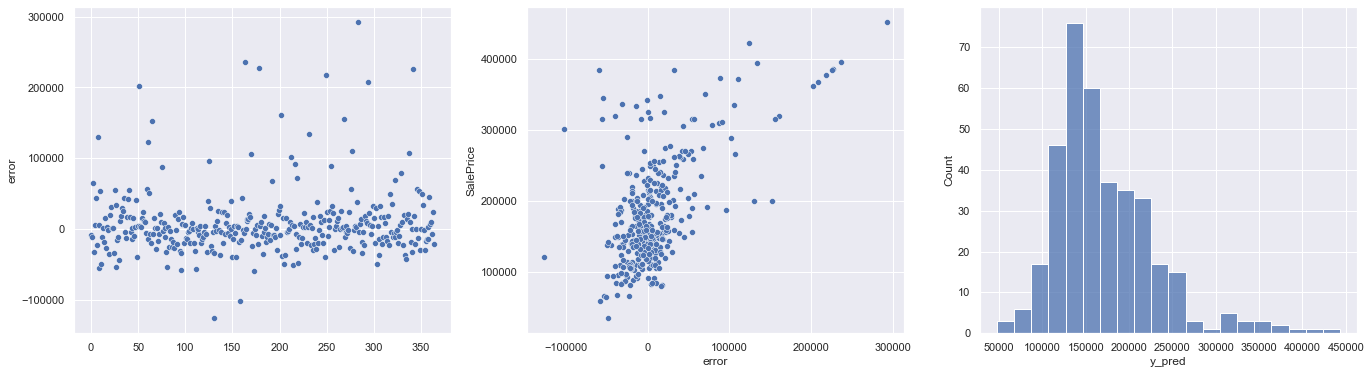

In [64]:
plot_error_distrib(df_plot)

In [65]:
ransag_val_metrcs = gets_metrics(df_plot,'Val')
ransag_val_metrcs

{'Val': {'MSLE': 0.05761875992537522, 'MAE': 26748.16037994883}}

<b> Test Data set

In [66]:
test_dataset = feature_transformation_1(test.fillna(0), dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
test_dataset = columniser(test_dataset,'SalePrice',numericals_to_use, categoricals_to_use)

In [67]:
scaled_test_dataset = prep_interactin_terms(dataset = test_dataset,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [68]:
X__test = scaled_test_dataset.iloc[:,0:-1]
Y_test = scaled_test_dataset.iloc[:,-1]
X__test_reten = X__test.assign(intercept = 1) ### artificial intercept
Y_test_pred = linearModelRanSac.predict(X__test_reten)

In [69]:
test_inversed_scaled_data = inverse_scaling(X__test, Y_test, scalerx, num_columns_head, cat_columns_head)
testpred_inversed_scaled_data = inverse_scaling(X__test, Y_test_pred, scalerx, num_columns_head, cat_columns_head)

In [70]:
df_plot = dataframe_to_plot(test_inversed_scaled_data, testpred_inversed_scaled_data)
df_plot['y_pred'] = correct_extreme_values(df_plot['y_pred'])
df_plot['error'] = df_plot['y_pred'] - df_plot['SalePrice']

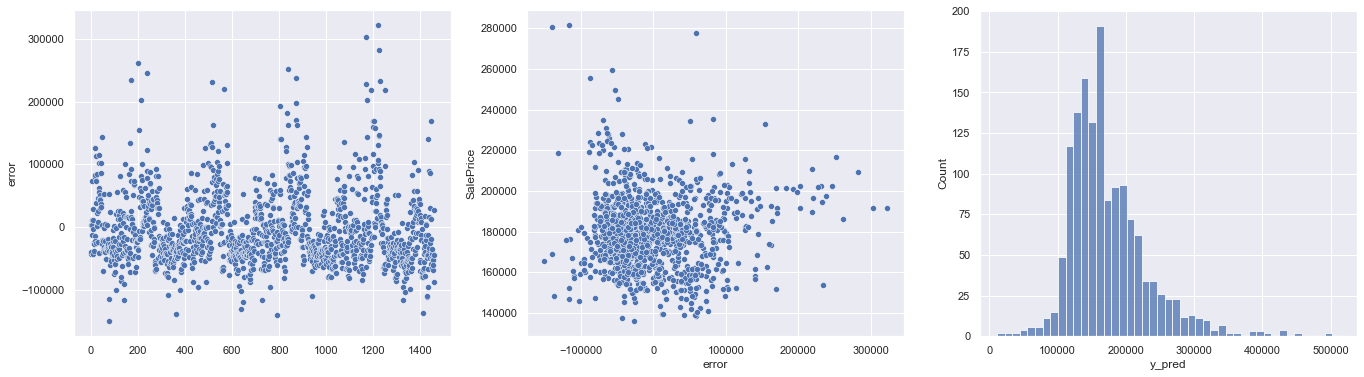

In [71]:
plot_error_distrib(df_plot)

In [72]:
ransag_test_metrcs = gets_metrics(df_plot,'Test')
ransag_test_metrcs

{'Test': {'MSLE': 0.10910031439155973, 'MAE': 44280.479092788395}}

### Lasso Regression

In [73]:
X__train = train_dataset_touse.iloc[:,0:-1]
Y_train = train_dataset_touse.iloc[:,-1]

In [74]:
n_alphas = 200
alphas = np.logspace(-6, -0.0001, n_alphas)

coefs = []
MAEs = []
for a in alphas:
    linearModel = Lasso(alpha=a, fit_intercept=True)
    linearModel.fit(X__train, Y_train)
    coefs.append(linearModel.coef_)
    Y_pred = linearModel.predict(X__train)
    MAE = mean_absolute_error(Y_train,Y_pred)
    MAEs.append(MAE)

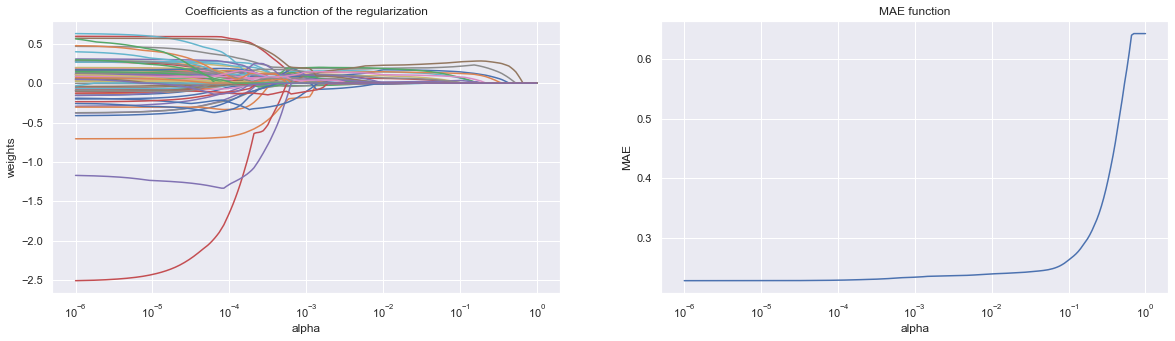

In [75]:
fig, ax = plt.subplots(1,2,figsize= (20,5))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('weights')
ax[0].set_title('Coefficients as a function of the regularization')
ax[0].axis('tight')

ax[1].plot(alphas, MAEs)
ax[1].set_xscale('log')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE function')
ax[1].axis('tight')

plt.show()

In [76]:
linearModel = Lasso(alpha=10**(-4), fit_intercept=True)
linearModel.fit(X__train, Y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [77]:
Y_pred = linearModel.predict(X__train)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.DataFrame({'y_train': Y_train, 'y_pred':Y_pred.reshape((Y_pred.shape[0],))})
df = df.assign(error = df.y_pred - df.y_train)

In [78]:
train_inversed_scaled_data = inverse_scaling(X__train, Y_train, scalerx, num_columns_head, cat_columns_head)
trainpred_inversed_scaled_data = inverse_scaling(X__train, Y_pred, scalerx, num_columns_head, cat_columns_head)

In [79]:
df_plot = dataframe_to_plot(train_inversed_scaled_data, trainpred_inversed_scaled_data)

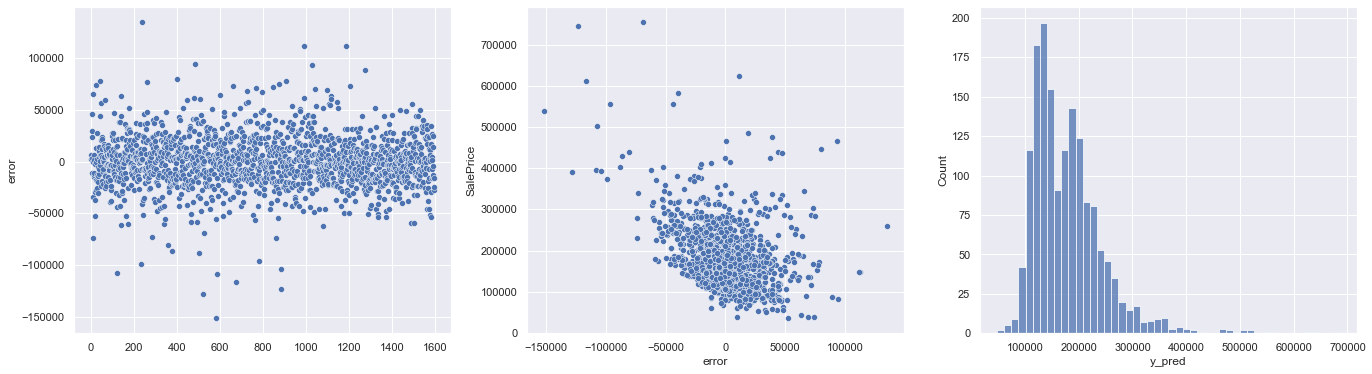

In [80]:
plot_error_distrib(df_plot)

In [81]:
lasso_train_metrcs = gets_metrics(df_plot,'Train')
lasso_train_metrcs

{'Train': {'MSLE': 0.023278320464759774, 'MAE': 18676.574861382953}}

<b> Validation Data

In [82]:
validation_dataset_prep = feature_transformation_1(validation_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
validation_dataset_prep = columniser(validation_dataset_prep,'SalePrice',numericals_to_use, categoricals_to_use)

In [83]:
scaled_validation_dataset = prep_interactin_terms(dataset = validation_dataset_prep,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [84]:
X__validation = scaled_validation_dataset.iloc[:,0:-1]
Y_validation = scaled_validation_dataset.iloc[:,-1]
Y_validation_pred = linearModel.predict(X__validation)

In [85]:
validation_inversed_scaled_data = inverse_scaling(X__validation, Y_validation, scalerx, num_columns_head, cat_columns_head)
validationpred_inversed_scaled_data = inverse_scaling(X__validation, Y_validation_pred, scalerx, num_columns_head, cat_columns_head)

In [86]:
df_plot = dataframe_to_plot(validation_inversed_scaled_data, validationpred_inversed_scaled_data)

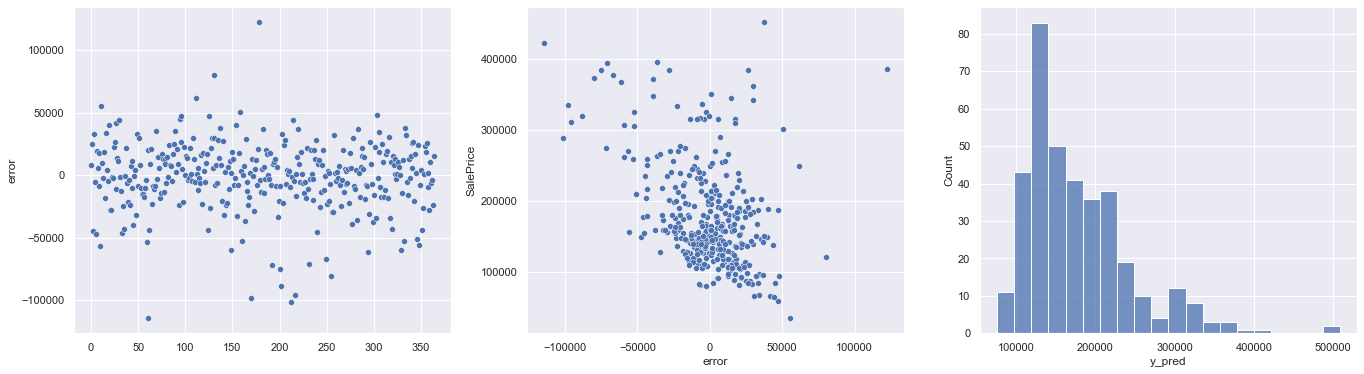

In [87]:
plot_error_distrib(df_plot)

In [88]:
lasso_val_metrcs = gets_metrics(df_plot,'Val')
lasso_val_metrcs

{'Val': {'MSLE': 0.025116452190160676, 'MAE': 19477.502768897764}}

<b> Test Data set

In [89]:
test_dataset = feature_transformation_1(test.fillna(0), dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
test_dataset = columniser(test_dataset,'SalePrice',numericals_to_use, categoricals_to_use)

In [90]:
scaled_test_dataset = prep_interactin_terms(dataset = test_dataset,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [91]:
X__test = scaled_test_dataset.iloc[:,0:-1]
Y_test = scaled_test_dataset.iloc[:,-1]
Y_test_pred = linearModel.predict(X__test)

In [92]:
test_inversed_scaled_data = inverse_scaling(X__test, Y_test, scalerx, num_columns_head, cat_columns_head)
testpred_inversed_scaled_data = inverse_scaling(X__test, Y_test_pred, scalerx, num_columns_head, cat_columns_head)

In [93]:
df_plot = dataframe_to_plot(test_inversed_scaled_data, testpred_inversed_scaled_data)

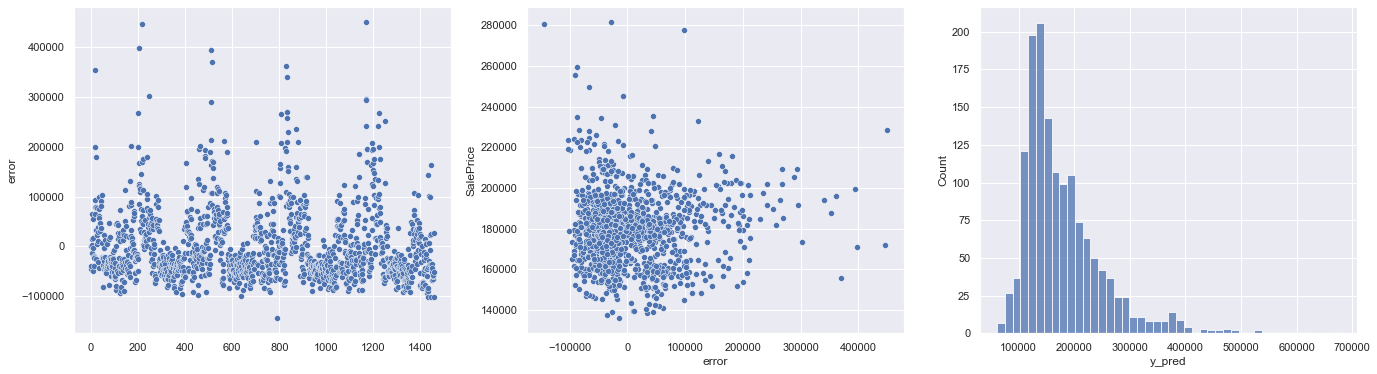

In [94]:
plot_error_distrib(df_plot)

In [95]:
lasso_test_metrcs = gets_metrics(df_plot,'Test')
lasso_test_metrcs

{'Test': {'MSLE': 0.12494640971695818, 'MAE': 53742.51666030878}}

### Ridge Regression

In [96]:
X__train = train_dataset_touse.iloc[:,0:-1]
Y_train = train_dataset_touse.iloc[:,-1]

In [97]:
n_alphas = 200
alphas = np.logspace(-5, -0.0001, n_alphas)

coefs = []
MAEs = []
for a in alphas:
    linearModel = Ridge(alpha=a, fit_intercept=True)
    linearModel.fit(X__train, Y_train)
    coefs.append(linearModel.coef_)
    Y_pred = linearModel.predict(X__train)
    MAE = mean_absolute_error(Y_train,Y_pred)
    MAEs.append(MAE)

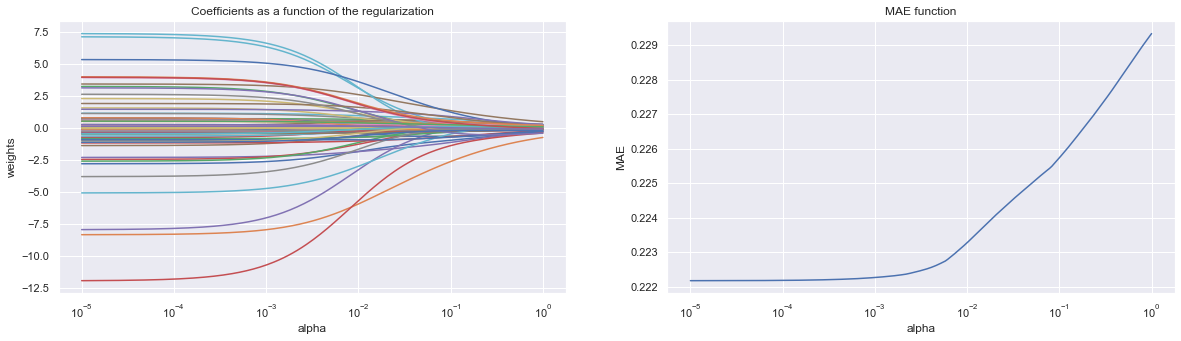

In [98]:
fig, ax = plt.subplots(1,2,figsize= (20,5))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('weights')
ax[0].set_title('Coefficients as a function of the regularization')
ax[0].axis('tight')

ax[1].plot(alphas, MAEs)
ax[1].set_xscale('log')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE function')
ax[1].axis('tight')

plt.show()

In [99]:
linearModel = Ridge(alpha=10**(-2.8), fit_intercept=True)
linearModel.fit(X__train, Y_train)

Ridge(alpha=0.001584893192461114, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001)

In [100]:
Y_pred = linearModel.predict(X__train)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.DataFrame({'y_train': Y_train, 'y_pred':Y_pred.reshape((Y_pred.shape[0],))})
df = df.assign(error = df.y_pred - df.y_train)

In [101]:
train_inversed_scaled_data = inverse_scaling(X__train, Y_train, scalerx, num_columns_head, cat_columns_head)
trainpred_inversed_scaled_data = inverse_scaling(X__train, Y_pred, scalerx, num_columns_head, cat_columns_head)

In [102]:
df_plot = dataframe_to_plot(train_inversed_scaled_data, trainpred_inversed_scaled_data)

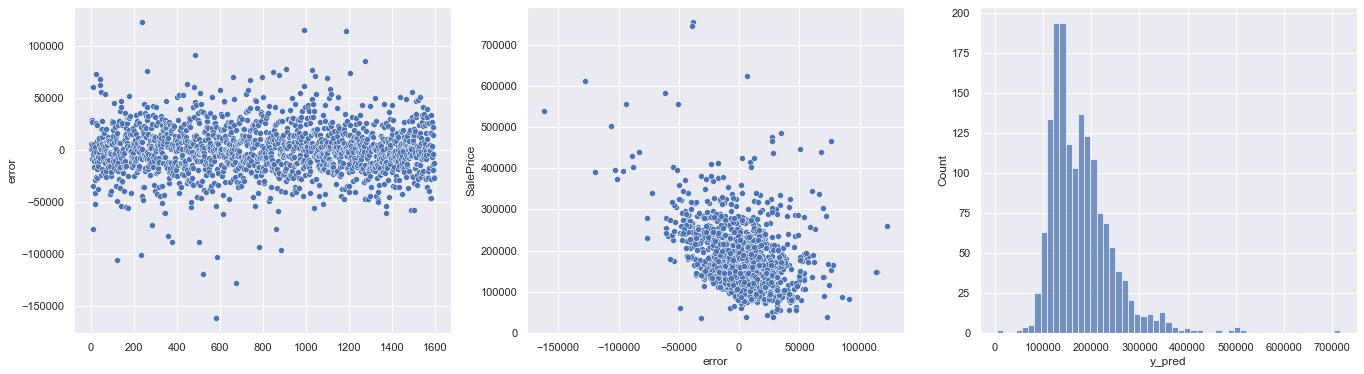

In [103]:
plot_error_distrib(df_plot)

In [104]:
ridge_train_metrcs = gets_metrics(df_plot,'Train')
ridge_train_metrcs

{'Train': {'MSLE': 0.025932899909836993, 'MAE': 18105.32450653218}}

<b> Validation Data

In [105]:
validation_dataset_prep = feature_transformation_1(validation_dataset, dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
validation_dataset_prep = columniser(validation_dataset_prep,'SalePrice',numericals_to_use, categoricals_to_use)

In [106]:
validation_dataset = prep_interactin_terms(dataset = validation_dataset_prep,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [107]:
X__validation = scaled_validation_dataset.iloc[:,0:-1]
Y_validation = scaled_validation_dataset.iloc[:,-1]
Y_validation_pred = linearModel.predict(X__validation)
Y_validation_pred = correct_extreme_values(Y_validation_pred)

In [108]:
validation_inversed_scaled_data = inverse_scaling(X__validation, Y_validation, scalerx, num_columns_head, cat_columns_head)
validationpred_inversed_scaled_data = inverse_scaling(X__validation, Y_validation_pred, scalerx, num_columns_head, cat_columns_head)

In [109]:
df_plot = dataframe_to_plot(validation_inversed_scaled_data, validationpred_inversed_scaled_data)

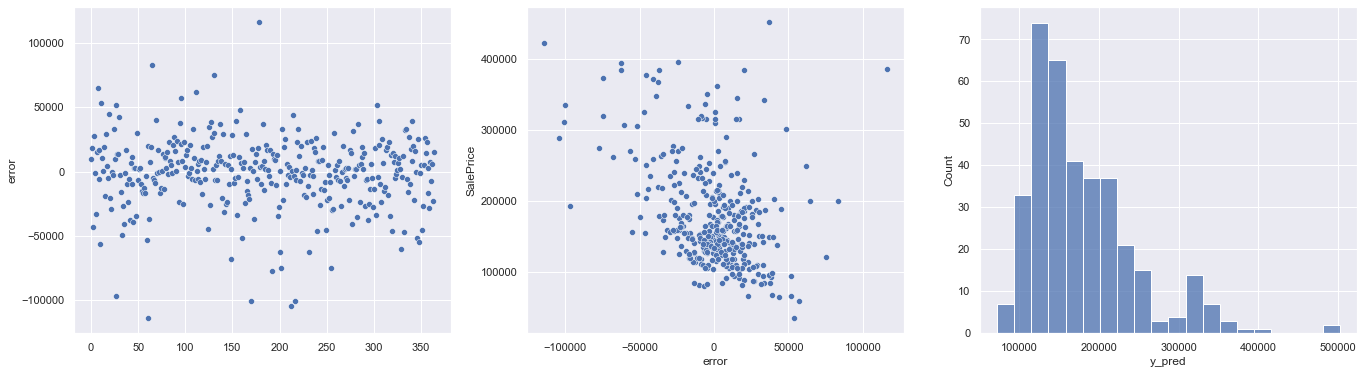

In [110]:
plot_error_distrib(df_plot)

In [111]:
ridge_val_metrcs = gets_metrics(df_plot,'Val')
ridge_val_metrcs

{'Val': {'MSLE': 0.026828116058094268, 'MAE': 19489.82409245069}}

<b> Test Data set

In [112]:
test_dataset = feature_transformation_1(test.fillna(0), dict_to_replace, additional_numerical, replacer_categorical, replacer_categorical_2, additional_numerical,[])
test_dataset = columniser(test_dataset,'SalePrice',numericals_to_use, categoricals_to_use)

In [113]:
scaled_test_dataset = prep_interactin_terms(dataset = test_dataset,
                      WholeCategoricals = selected_categorical_features,
                      WholeNumericals = selected_numerical_features, SelectedDummies = selected_categorical_dummies_features,
                      dataReferencial = int_terms_df,
                      scale =  False, scalers_exist = scalerx,
                      base_columns = (num_columns_head, cat_columns_head))

In [114]:
X__test = scaled_test_dataset.iloc[:,0:-1]
Y_test = scaled_test_dataset.iloc[:,-1]
Y_test_pred = linearModel.predict(X__test)
Y_test_pred = correct_extreme_values(Y_test_pred)

In [115]:
test_inversed_scaled_data = inverse_scaling(X__test, Y_test, scalerx, num_columns_head, cat_columns_head)
testpred_inversed_scaled_data = inverse_scaling(X__test, Y_test_pred, scalerx, num_columns_head, cat_columns_head)

In [116]:
df_plot = dataframe_to_plot(test_inversed_scaled_data, testpred_inversed_scaled_data).dropna()

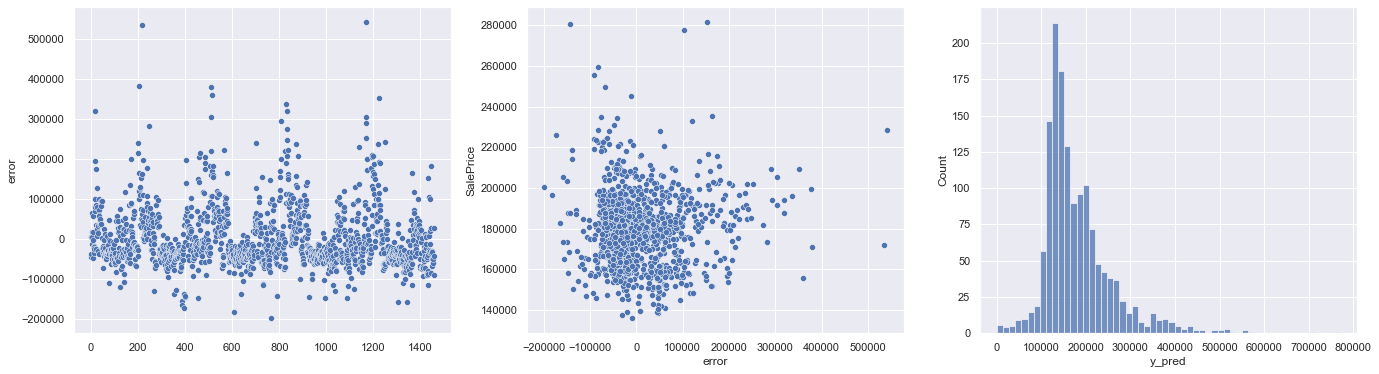

In [117]:
plot_error_distrib(df_plot)

In [118]:
ridge_test_metrcs = gets_metrics(df_plot,'Test')
ridge_test_metrcs

{'Test': {'MSLE': 0.19611357108630453, 'MAE': 55194.60890325795}}

### Summary performance

In [119]:
ransag_sum = pd.DataFrame({**ransag_train_metrcs, **ransag_val_metrcs, **ransag_test_metrcs} ).transpose()
lasso_sum = pd.DataFrame({**lasso_train_metrcs, **lasso_val_metrcs, **lasso_test_metrcs}).transpose()
ridge_sum = pd.DataFrame({**ridge_train_metrcs, **ridge_val_metrcs, **ridge_test_metrcs}).transpose()

In [120]:
ransag_sum['model'] = 'ransag'
lasso_sum['model'] = 'lasso'
ridge_sum['model'] = 'ridge'
pd.set_option('display.float_format', lambda x: '%.4f' % x)
summary_metric = pd.concat([ransag_sum,lasso_sum,ridge_sum],axis = 1)
summary_metric

,MSLE,MAE,model,MSLE,MAE,model,MSLE,MAE,model
Train,0.0717,25237.5928,ransag,0.0233,18676.5749,lasso,0.0259,18105.3245,ridge
Val,0.0576,26748.1604,ransag,0.0251,19477.5028,lasso,0.0268,19489.8241,ridge
Test,0.1091,44280.4791,ransag,0.1249,53742.5167,lasso,0.1961,55194.6089,ridge


In [121]:
gato
summary_metric.to_csv('With Augmentation MLS.csv')

### Conclusion:

In [122]:
pd.read_csv('No Augmentation MLS.csv')

,Unnamed: 0,MSLE,MAE,model,MSLE.1,MAE.1,model.1,MSLE.2,MAE.2,model.2
0,Train,0.0635,29967.3357,ransag,0.0251,19557.3089,lasso,0.0248,18949.7200,ridge
1,Val,0.0553,29197.7060,ransag,0.0252,19468.2854,lasso,0.0264,19372.8872,ridge
2,Test,0.1300,53072.0207,ransag,0.1309,54794.8768,lasso,0.2080,56403.1164,ridge


In [123]:
pd.read_csv('With Augmentation MLS.csv')

,Unnamed: 0,MSLE,MAE,model,MSLE.1,MAE.1,model.1,MSLE.2,MAE.2,model.2
0,Train,0.0717,25237.5928,ransag,0.0233,18676.5749,lasso,0.0259,18105.3245,ridge
1,Val,0.0576,26748.1604,ransag,0.0251,19477.5028,lasso,0.0268,19489.8241,ridge
2,Test,0.1091,44280.4791,ransag,0.1249,53742.5167,lasso,0.1961,55194.6089,ridge


key notes:
* using some augmentation helped to improve some models
+ all models have some advantages and desadvantages
* adding the interaction terms and non linnear terms helped to improve model flexibility
* in needs parameter tunning and cross validation and improve variable selection to dont lose interaction terms